In [1]:
import pandas as pd
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt

date1 = input("動的実験の日付を入力してください: ")

動的実験の日付を入力してください:  20231220


In [2]:
date2 = input("静的実験の日付を入力してください: ")

静的実験の日付を入力してください:  20231220


In [18]:
count2 = input("静的実験の測定回数を入力してください(例:1): ") 

静的実験の測定回数を入力してください(例:1):  2


In [5]:
measurement_kind = input("マッキベンの種類を入力してください(4s or 4l or 6 or s or u): ")  

マッキベンの種類を入力してください(4s or 4l or 6 or s or u):  s


動的実験の測定回数を入力してください(例:1):  5


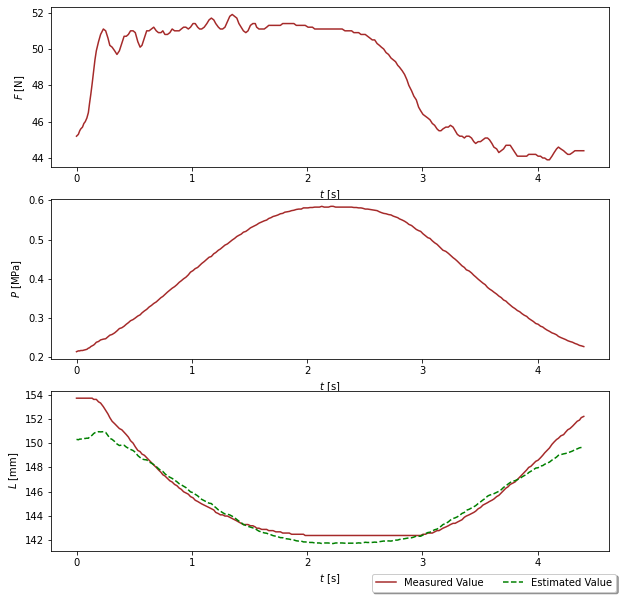

In [23]:
count = input("動的実験の測定回数を入力してください(例:1): ") 

file_path = f"C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\data\\pressure_control\\output\\{date1}_{count}_{measurement_kind}_0.5_partial_p_output_3d_by_{count2}.csv"
df = pd.read_csv(file_path)

file_path = f"C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\data\\estimated_parameter_Ls\\{date2}_{count2}_{measurement_kind}_fp.csv"
df_parameters = pd.read_csv(file_path, index_col=0)

fit_params_path = 'C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\data\\length_pressure\\fit_params.csv'
fit_params = pd.read_csv(fit_params_path, index_col=0)


c4_ec, c3_ec, c2_ec, c1_ec, c0_ec = df_parameters.loc[['c4_ec', 'c3_ec', 'c2_ec', 'c1_ec', 'c0_ec']].values

# 定数 A, B の値を measurement_kind に基づいて設定
if measurement_kind == '6':
    constant_A, constant_B = 19, 34
elif measurement_kind == '4s':
    constant_A, constant_B = 10, 27
elif measurement_kind == '4ss':
    constant_A, constant_B = 16, 33
elif measurement_kind == 's':
    constant_A, constant_B = 25,36
else:
    # デフォルト値またはエラーハンドリングが必要な場合に設定してください
    constant_A, constant_B = 0, 0  # デフォルト値として0を設定

#以下L_uの推定
parameter_mapping = {'6': 'PAM-A', '4s': 'PAM-B', '4ss': 'PAM-C', 's': 'PAM-D'}
selected_parameter = parameter_mapping.get(measurement_kind.lower())
selected_slope = fit_params.loc[selected_parameter, 'Slope']
selected_intercept = fit_params.loc[selected_parameter, 'Intercept']

# Pressure Contraction および Force Contraction が空白でない場合の計算
mask_contraction = (df['pressure_contraction'].notnull()) & (df['force_contraction'].notnull())
if mask_contraction.any():
    df_contraction = df[mask_contraction]

    def calculate_lengths_contraction(row):
        P = row['pressure_contraction']
        F = row['force_contraction']
        L_solution = fsolve(lambda L: c4_ec * P**3 * L + c3_ec * P**2 * L**2 + c2_ec * P * L**3 + c1_ec * L**4 + c0_ec * L - F, 21.0)
        return L_solution[0] if L_solution[0] > 0 else np.nan

    df.loc[mask_contraction, 'Estimated_Stretched_Length_Contraction'] = df_contraction.apply(calculate_lengths_contraction, axis=1)

    # Unstretched Length の計算
    df.loc[mask_contraction, 'Estimated_Unstretched_Length_Contraction'] = (
        selected_slope * df_contraction['pressure_contraction'] + selected_intercept
    )

# Pressure Extension および Force Extension が空白でない場合の計算
mask_extension = (df['pressure_extension'].notnull()) & (df['force_extension'].notnull())
if mask_extension.any():
    df_extension = df[mask_extension]

    def calculate_lengths_extension(row):
        P = row['pressure_extension']
        F = row['force_extension']
        L_solution = fsolve(lambda L: c4_ec * P**3 * L + c3_ec * P**2 * L**2 + c2_ec * P * L**3 + c1_ec * L**4 + c0_ec * L - F, 16.0)
        return L_solution[0] if L_solution[0] > 0 else np.nan

    df.loc[mask_extension, 'Estimated_Stretched_Length_Extension'] = df_extension.apply(calculate_lengths_extension, axis=1)

    # Unstretched Length の計算
    df.loc[mask_extension, 'Estimated_Unstretched_Length_Extension'] = (
        selected_slope * df_extension['pressure_extension'] + selected_intercept
    )

# Estimated Length 列の計算
df['Estimated_Length_Contraction'] = df['Estimated_Stretched_Length_Contraction'] + df['Estimated_Unstretched_Length_Contraction']
df['Estimated_Length_Extension'] = df['Estimated_Stretched_Length_Extension'] + df['Estimated_Unstretched_Length_Extension']
   
    
df['real_length_contraction'] = df['length_contraction'] - constant_B
df['Real_Estimated_Length_Contraction'] = df['Estimated_Length_Contraction'] - constant_A
df['real_length_extension'] = df['length_extension'] - constant_B
df['Real_Estimated_Length_Extension'] = df['Estimated_Length_Extension'] - constant_A

df['real_length'] = df['real_length_contraction'].combine_first(df['real_length_extension'])
df['time_elapsed'] = df['time_contraction'].combine_first(df['time_extension'])


result_path = f'C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\data\\estimated_L_for_dynamic_experiment\\{date1}_{count}_{measurement_kind}_by_{count2}_L_estimation_ec.csv'
df.to_csv(result_path, index=False)

column = df[["time", "length", "pressure", "force",'time_elapsed','time_contraction','time_extension',"estimated_contraction_length","estimated_extension_length","Real_Estimated_Length_Contraction","real_length","Real_Estimated_Length_Extension"]]

time_values = column['time_elapsed'].values
pressure_values = column["pressure"].values
length_values = column["length"].values
force_values = column["force"].values
time_contraction = column["time_contraction"].values
time_extension = column["time_extension"].values
real_length = column["real_length"]
Real_Estimated_Length_Contraction = column["Real_Estimated_Length_Contraction"]
Real_Estimated_Length_Extension = column["Real_Estimated_Length_Extension"]


# センサー値グラフ
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
plt.plot(time_values, force_values, color='brown', label='Measured Value')
plt.xlabel('$t$ [s]')
plt.ylabel('$F$ [N]')

plt.subplot(3, 1, 2)
plt.plot(time_values, pressure_values, color='brown', label='Measured Value')
plt.xlabel('$t$ [s]')
plt.ylabel('$P$ [MPa]')

plt.subplot(3, 1, 3)
plt.plot(time_values, real_length,color='brown', label='Measured Value')
plt.plot(time_contraction, Real_Estimated_Length_Contraction, '--', color='green', label='Estimated Value')
plt.plot(time_extension, Real_Estimated_Length_Extension, '--', color='green')
plt.xlabel('$t$ [s]')
plt.ylabel('$L$ [mm]')

# グラフ全体の凡例を追加
handles, labels = plt.gca().get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.74, 0.1), ncol=5, fancybox=True, shadow=True)
# グラフを保存

file_name_partial_com15 = f"{date1}_{count}_{measurement_kind}"
save_path_com15 = 'C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\graph\\estimated_L_for_dynamic_experiment\\'
plt.savefig(save_path_com15 + file_name_partial_com15 + f"_by_{count2}_ec.jpg")

# グラフを表示
plt.show()

# #以下2D

# file_path = f"C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\data\\pressure_control\\output\\{date1}_{count}_{measurement_kind}_0.6_partial_p_output_3d_by_{count2}.csv"
# df = pd.read_csv(file_path)

# file_path = f"C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\data\\estimated_parameter_Ls\\{date2}_{count2}_{measurement_kind}_2d_fp.csv"
# df_parameters = pd.read_csv(file_path, index_col=0)


# c3_c, c2_c, c1_c, c0_c = df_parameters.loc[['c3_c', 'c2_c', 'c1_c', 'c0_c']].values
# c3_e, c2_e, c1_e, c0_e = df_parameters.loc[['c3_e', 'c2_e', 'c1_e', 'c0_e']].values

# # 定数 A, B の値を measurement_kind に基づいて設定
# if measurement_kind == '6':
#     constant_A, constant_B = 19, 34
# elif measurement_kind == '4s':
#     constant_A, constant_B = 10, 27
# elif measurement_kind == '4ss':
#     constant_A, constant_B = 17, 33
# elif measurement_kind == 's':
#     constant_A, constant_B = 25, 41
# else:
#     # デフォルト値またはエラーハンドリングが必要な場合に設定してください
#     constant_A, constant_B = 0, 0  # デフォルト値として0を設定

# #以下L_uの推定
# parameter_mapping = {'6': 'PAM-A', '4s': 'PAM-B', '4ss': 'PAM-C', 's': 'PAM-D'}
# selected_parameter = parameter_mapping.get(measurement_kind.lower())
# selected_slope = fit_params.loc[selected_parameter, 'Slope']
# selected_intercept = fit_params.loc[selected_parameter, 'Intercept']

# # Pressure Contraction および Force Contraction が空白でない場合の計算
# mask_contraction = (df['pressure_contraction'].notnull()) & (df['force_contraction'].notnull())
# if mask_contraction.any():
#     df_contraction = df[mask_contraction]

#     def calculate_lengths_contraction(row):
#         P = row['pressure_contraction']
#         F = row['force_contraction']
#         L_solution = fsolve(lambda L:  c3_c * P**2 * L + c2_c * P * L**2 + c1_c * L**3 + c0_c * L - F, 21.0)
#         return L_solution[0] if L_solution[0] > 0 else np.nan

#     df.loc[mask_contraction, 'Estimated_Stretched_Length_Contraction'] = df_contraction.apply(calculate_lengths_contraction, axis=1)

#     # Unstretched Length の計算
#     df.loc[mask_contraction, 'Estimated_Unstretched_Length_Contraction'] = (
#         selected_slope * df_contraction['pressure_contraction'] + selected_intercept
#     )

# # Pressure Extension および Force Extension が空白でない場合の計算
# mask_extension = (df['pressure_extension'].notnull()) & (df['force_extension'].notnull())
# if mask_extension.any():
#     df_extension = df[mask_extension]

#     def calculate_lengths_extension(row):
#         P = row['pressure_extension']
#         F = row['force_extension']
#         L_solution = fsolve(lambda L:  c3_e * P**2 * L + c2_e * P * L**2+ c1_e * L**3 + c0_e * L - F, 16.0)
#         return L_solution[0] if L_solution[0] > 0 else np.nan

#     df.loc[mask_extension, 'Estimated_Stretched_Length_Extension'] = df_extension.apply(calculate_lengths_extension, axis=1)

#     # Unstretched Length の計算
#     df.loc[mask_extension, 'Estimated_Unstretched_Length_Extension'] = (
#         selected_slope * df_extension['pressure_extension'] + selected_intercept
#     )

# # Estimated Length 列の計算
# df['Estimated_Length_Contraction'] = df['Estimated_Stretched_Length_Contraction'] + df['Estimated_Unstretched_Length_Contraction']
# df['Estimated_Length_Extension'] = df['Estimated_Stretched_Length_Extension'] + df['Estimated_Unstretched_Length_Extension']
   
    
# df['real_length_contraction'] = df['length_contraction'] - constant_B
# df['Real_Estimated_Length_Contraction'] = df['Estimated_Length_Contraction'] - constant_A
# df['real_length_extension'] = df['length_extension'] - constant_B
# df['Real_Estimated_Length_Extension'] = df['Estimated_Length_Extension'] - constant_A

# df['real_length'] = df['real_length_contraction'].combine_first(df['real_length_extension'])
# df['time_elapsed'] = df['time_contraction'].combine_first(df['time_extension'])


# result_path = f'C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\data\\estimated_L_for_dynamic_experiment\\{date1}_{count}_{measurement_kind}_by_{count2}_2d_L_estimation.csv'
# df.to_csv(result_path, index=False)

# column = df[["time", "length", "pressure", "force",'time_elapsed','time_contraction','time_extension',"estimated_contraction_length","estimated_extension_length","Real_Estimated_Length_Contraction","real_length","Real_Estimated_Length_Extension"]]

# time_values = column['time_elapsed'].values
# pressure_values = column["pressure"].values
# length_values = column["length"].values
# force_values = column["force"].values
# time_contraction = column["time_contraction"].values
# time_extension = column["time_extension"].values
# real_length = column["real_length"]
# Real_Estimated_Length_Contraction = column["Real_Estimated_Length_Contraction"]
# Real_Estimated_Length_Extension = column["Real_Estimated_Length_Extension"]


# # センサー値グラフ
# plt.figure(figsize=(10, 10))

# plt.subplot(3, 1, 1)
# plt.plot(time_values, force_values, color='brown', label='Measured Value')
# plt.xlabel('$t$ [s]')
# plt.ylabel('$F$ [N]')

# plt.subplot(3, 1, 2)
# plt.plot(time_values, pressure_values, color='brown', label='Measured Value')
# plt.xlabel('$t$ [s]')
# plt.ylabel('$P$ [MPa]')

# plt.subplot(3, 1, 3)
# plt.plot(time_values, real_length,color='brown', label='Measured Value')
# plt.plot(time_contraction, Real_Estimated_Length_Contraction, '--', color='green', label='Estimated Value')
# plt.plot(time_extension, Real_Estimated_Length_Extension, '--', color='green')
# plt.xlabel('$t$ [s]')
# plt.ylabel('$L$ [mm]')

# # グラフ全体の凡例を追加
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.74, 0.1), ncol=5, fancybox=True, shadow=True)
# # グラフを保存

# file_name_partial_com15 = f"{date1}_{count}_{measurement_kind}"
# save_path_com15 = 'C:\\Users\\Mizuki\\University\\Reserch\\length_sensor\\JupyterLab\\graph\\estimated_L_for_dynamic_experiment\\'
# plt.savefig(save_path_com15 + file_name_partial_com15 + f"2d_by_{count2}.jpg")

# # グラフを表示
# plt.show()